In [1]:
# Source:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
import pandas as pd
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
# load data
dataset = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv", header=None)
# split data into X and y
X = dataset.iloc[:,0:8]
y = dataset.iloc[:,8]
display(dataset.head())

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


[0.         0.5236731  0.         0.         0.         0.26142377
 0.09280603 0.12209713]


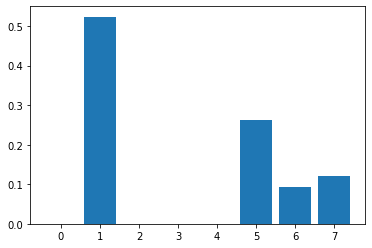

In [2]:
model = XGBClassifier(n_estimators=3,max_depth=2)
model.fit(X, y)
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

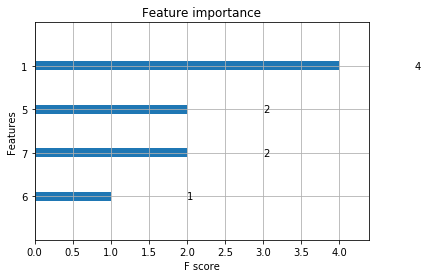

In [3]:
# Alternatively, we could use xgboost's built-in plot
from xgboost import plot_importance
plot_importance(model)

Note:

1. Features with zero feature_importance_ don’t show in trees_to_dataframe(). You can check what they are with:
X_train.columns[[ x not in k[‘Feature’].unique() for x in X_train.columns]]

2. The feature importance ranks for ‘weight’ and ‘gain’ types can be quite different. Be careful when choosing features based on the plot. I would choose gain over weight because gain reflects the feature’s power of grouping similar instances into a more homogeneous child node at the split.

In [4]:
# https://stackoverflow.com/questions/57360703/feature-importance-gain-in-xgboost
# Gain = average gain of splits which use the feature = average all the gain values of the feature if it appears multiple times
# Normalized gain = Proportion of average gain out of total average gain
k = model.get_booster().trees_to_dataframe()
display(k.shape)
k.head()

(21, 10)

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,1,128.000000,0-1,0-2,0-1,125.387550,192.00
1,0,1,0-1,7,29.000000,0-3,0-4,0-3,27.484222,121.25
2,0,2,0-2,5,29.950001,0-5,0-6,0-5,36.069267,70.75
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,-0.490909,67.75
4,0,4,0-4,Leaf,NaN,NaN,NaN,NaN,-0.198165,53.50


In [5]:
# How to get back feature_importances_ (gain based) from plot_importance fscore
# Calculate two types of feature importance:
# Weight = number of times a feature appears in tree
# Gain = average gain of splits which use the feature = average all the gain values of the feature if it appears multiple times
# Normalized gain = Proportion of average gain out of total average gain
group = k[k['Feature']!='Leaf'].groupby('Feature').agg(fscore = ('Gain', 'count'),
                                                       feature_importance_gain = ('Gain', 'mean'))

# Feature importance same as plot_importance(importance_type = ‘weight’), default value
group['fscore'].sort_values(ascending=False)

# Feature importance same as clf.feature_importance_ default = ‘gain’
group['feature_importance_gain_norm'] = group['feature_importance_gain']/group['feature_importance_gain'].sum()
group

,fscore,feature_importance_gain,feature_importance_gain_norm
Feature,,,
1,4,67.499500,0.523673
5,2,33.696541,0.261424
6,1,11.962349,0.092806
7,2,15.737862,0.122097


# Gain in regression in make more sense

In [7]:
from sklearn.datasets import make_regression
noise=0.1
X, y, coef = make_regression(n_samples=100, n_features=5, noise=noise, coef=True)
display(X.shape)
display(coef)
display(y[:10])

(100, 5)

array([45.18594663, 68.94285989, 41.11127567, 54.19466169, 72.62210442])

array([ -14.98629049,   67.14564271, -367.74480886, -135.91254138,
        -15.02066593, -102.23488225,   39.91473237, -207.77185183,
        108.22880746, -138.76726018])

In [13]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=2,max_depth=3,objective ='reg:squarederror')
model.fit(X, y)
k = model.get_booster().trees_to_dataframe()
display(k.shape)
k.head()

(30, 10)

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,f1,-0.078444,0-1,0-2,0-1,435249.5940,100.0
1,0,1,0-1,f4,-0.609663,0-3,0-4,0-3,190447.8440,49.0
2,0,2,0-2,f3,-0.196904,0-5,0-6,0-5,233262.6250,51.0
3,0,3,0-3,f1,-0.717864,0-7,0-8,0-7,32626.8750,18.0
4,0,4,0-4,f2,1.036812,0-9,0-10,0-9,85055.5078,31.0


In [16]:
# Now, what will happen if I scale the y
model.fit(X, y*100)
k = model.get_booster().trees_to_dataframe()
display(k.head())
display(k['Gain'].describe())
display(k['Cover'].describe())

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,f1,-0.078444,0-1,0-2,0-1,4.352786e+09,100.0
1,0,1,0-1,f4,-0.609663,0-3,0-4,0-3,1.905696e+09,49.0
2,0,2,0-2,f3,-0.196904,0-5,0-6,0-5,2.332606e+09,51.0
3,0,3,0-3,f1,-0.717864,0-7,0-8,0-7,3.278100e+08,18.0
4,0,4,0-4,f2,1.036812,0-9,0-10,0-9,8.502460e+08,31.0


count    3.000000e+01
mean     5.933484e+08
std      1.018747e+09
min     -6.580321e+03
25%      2.591626e+02
50%      4.123588e+03
75%      6.979274e+08
max      4.352786e+09
Name: Gain, dtype: float64

count     30.000000
mean      26.666667
std       26.567200
min        2.000000
25%        9.000000
50%       18.500000
75%       31.750000
max      100.000000
Name: Cover, dtype: float64

Gain increase by 10^4, or square of 10^2. So Gain in this case is the squared error. <br>
The parameter <i>gamma</i> and <i>learning rate</i> are based on Gain, so it needs to be the same order of magnitude.

### Cover
Source: https://stackoverflow.com/questions/33520460/how-is-xgboost-cover-calculated
Cover: the sum of second order gradient (Hessian) of training data classified to the leaf, if it is square loss, this simply corresponds to the number of instances in that branch. Deeper in the tree a node is, lower this metric will be.

For logistic regression, cover can be calculated without the true label. Actual it is:
$$(# number of observation) * p * (1-p)$$